Hello Kagglers! In this notebook I would like to show you how to analysis and predict very simple dataset.

**Importing libraries**

In [16]:
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

**Loading data**

In [2]:
train_path = os.path.join('datasets', 'titanic', 'train.csv')
test_path = os.path.join('datasets', 'titanic', 'test.csv')

train_df = pd.read_csv(train_path, index_col='PassengerId')
test_df = pd.read_csv(test_path, index_col='PassengerId')

print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

train_df.head()

Train size:  (891, 11)
Test size:  (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Data is not really large. There are only 891 rows in train set and 418 rows in the test set. Comparing to other datasets that are used in machine learning it is REALLY tine. There are 11 columns. The goal is simple - we want to develop the algorith that uses 10 features and predict target (Survived).

In [135]:
title = ['Train data', 'Test data']
for i, dataset in enumerate([train_df, test_df]):
    print(title[i])
    null_values = dataset.isna().sum() / train_df.shape[0]
    print(null_values[null_values > 0].sort_values(ascending=False))
    print()

Train data
Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

Test data
Cabin    0.367003
Age      0.096521
Fare     0.001122
dtype: float64



We have a few null values but not too much. 

Generallly we should not look at test data before evaluating a final model. However checking null values is an exemption. Most of machine learning model expect data with no null values and it is important to solve that problem.

**Exploratory Data Analysis**

The purpose of this notebook is to predict whether a passanger survived or not. It always good to look at a target columns and see the distribution or like in this example pie chart.

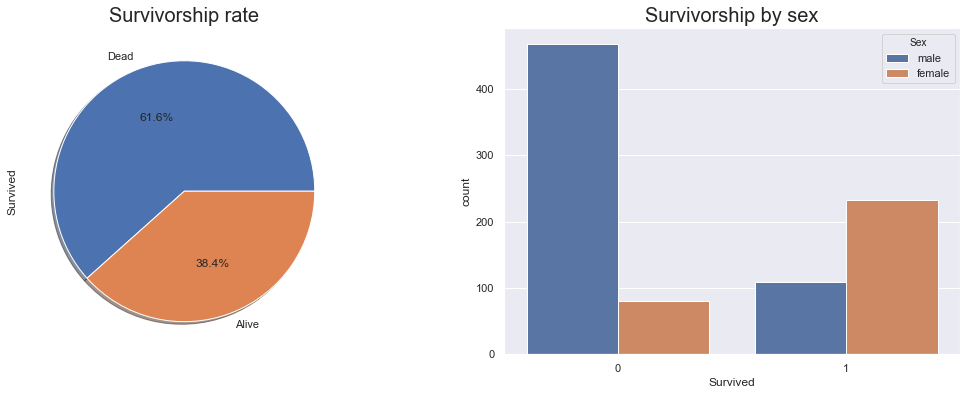

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
train_df['Survived'].value_counts().plot.pie(shadow=True, labels=['Dead', 'Alive'], autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('Survivorship rate', fontsize=20)

sns.countplot(x='Survived', hue='Sex', data=train_df, ax=axes[1])
axes[1].set_title('Survivorship by sex', fontsize=20);

Unfortunately most people died. Out of 891 people in train data 61.6% people died. On titanic cruise there were more men than women. Suprisingly most people who survived were women. It shows that women had a priority during rescue. There were real gentlemen.

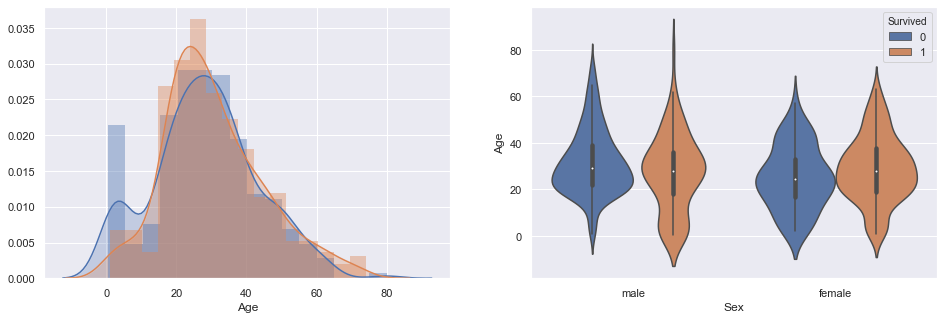

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

kde_kwargs=dict(hist_kws=dict(edgecolor='none'),
                kde_kws={"shade": True})

age_alive = train_df.loc[train_df['Survived'] == 1]
age_dead = train_df.loc[train_df['Survived'] == 0]

sns.distplot(age_alive['Age'], label='Alive', ax=ax1, **kde_kwargs)
sns.distplot(age_dead['Age'], label='Dead', ax=ax1, **kde_kwargs)
sns.violinplot(y='Age', x='Sex', hue='Survived', data=train_df, ax=ax2)

Children first!!! It is clear that most of especially young people survived. Most of passangers where in their 20s

We can see the relationship between Sex, Age and Survivorship in the same time. We can see that especially young man died. It is not true for women.

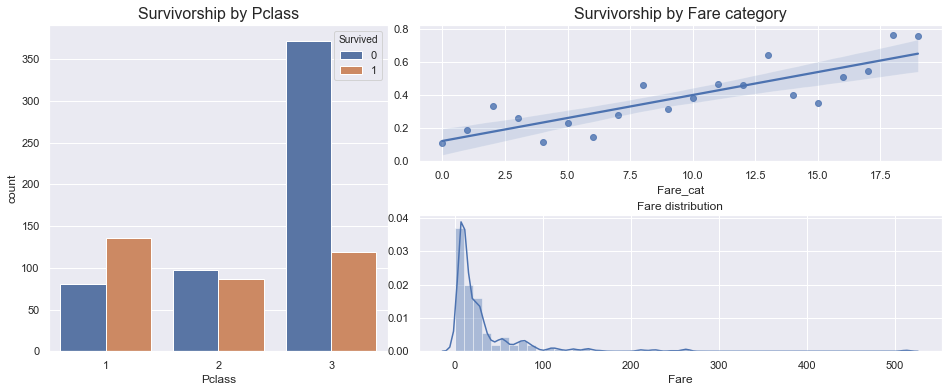

In [93]:
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(2, 5, hspace=0.4)

ax1 = fig.add_subplot(grid[:, 0:2])
ax2 = fig.add_subplot(grid[0, 2:])
ax3 = fig.add_subplot(grid[1, 2:])

sns.countplot(x='Pclass', hue='Survived', data=train_df, ax=ax1)
ax1.set_title('Survivorship by Pclass', fontsize=16)

train_df['Fare_cat'] = pd.qcut(train_df['Fare'], q=20, labels=False)
temp = train_df.groupby('Fare_cat')['Survived'].mean()
sns.regplot(x=temp.index, y=temp.values, ax=ax2)
ax2.set_title('Survivorship by Fare category', fontsize=16)

sns.distplot(train_df['Fare'], ax=ax3)
ax3.set_title('Fare distribution');

Text(0.5, 1.0, 'Number of parents for children')

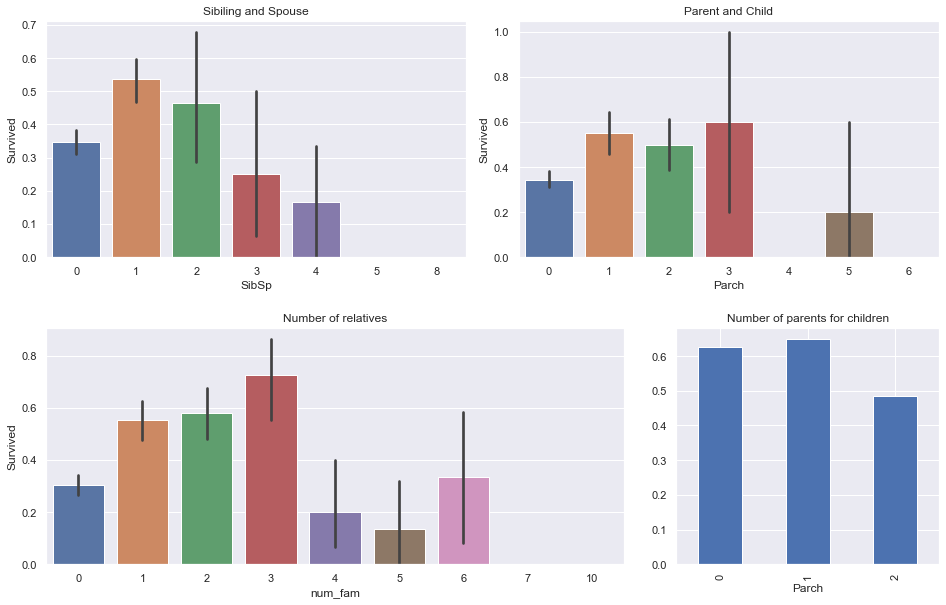

In [98]:
fig = plt.figure(figsize=(16, 10))
grid = plt.GridSpec(2, 6, hspace=0.3, wspace=0.5)
ax1 = fig.add_subplot(grid[0, :3])
ax2 = fig.add_subplot(grid[0, 3:])
ax3 = fig.add_subplot(grid[1, :4])
ax4 = fig.add_subplot(grid[1, 4:])

sns.barplot(x='SibSp', y='Survived', data=train_df, ax=ax1)
ax1.set_title('Sibiling and Spouse')
sns.barplot(x='Parch', y='Survived', data=train_df, ax=ax2)
ax2.set_title('Parent and Child')

temp = train_df.copy()
temp['num_fam'] = temp['Parch'] + temp['SibSp'] 
sns.barplot(x='num_fam', y='Survived', data=temp, ax=ax3)
ax3.set_title('Number of relatives')

child_survived = train_df.loc[train_df['Age'] < 15].groupby('Parch')['Survived'].mean()
child_survived.plot(kind='bar', ax=ax4)
ax4.set_title('Number of parents for children')

Accoring to documentation dataset defines family relations in this way:

1. Parch
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    * Some children travelled only with a nanny, therefore parch=0 for them.
    
2. SibSp
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

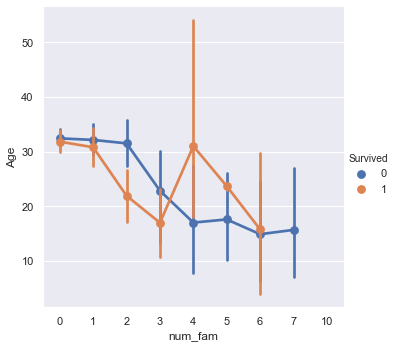

In [123]:
ax = sns.catplot(x='num_fam', y='Age', hue='Survived', data=temp, kind='point')

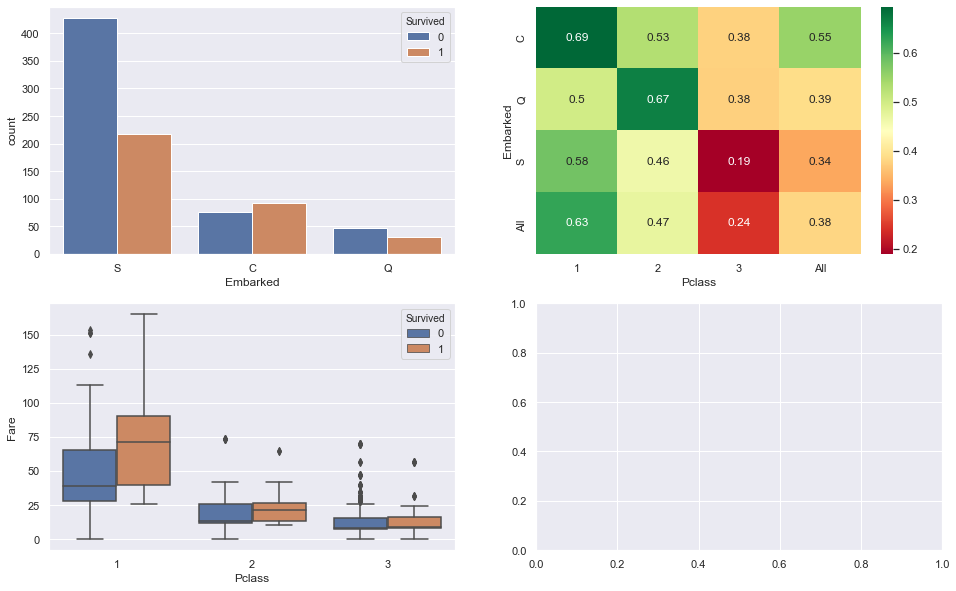

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))
ax1, ax2, ax3, ax4 = axes.flat
sns.countplot(x='Embarked', hue='Survived', data=train_df, ax=ax1)

emb_pclass_pivot = pd.pivot_table(train_df, values='Survived', 
                                  index='Embarked', columns='Pclass', 
                                  margins=True)
sns.heatmap(emb_pclass_pivot, annot=True, cmap='RdYlGn', ax=ax2)

sns.boxplot(x='Pclass', y='Fare', hue='Survived', 
            data=train_df.loc[train_df['Fare'] < 200], ax=ax3)

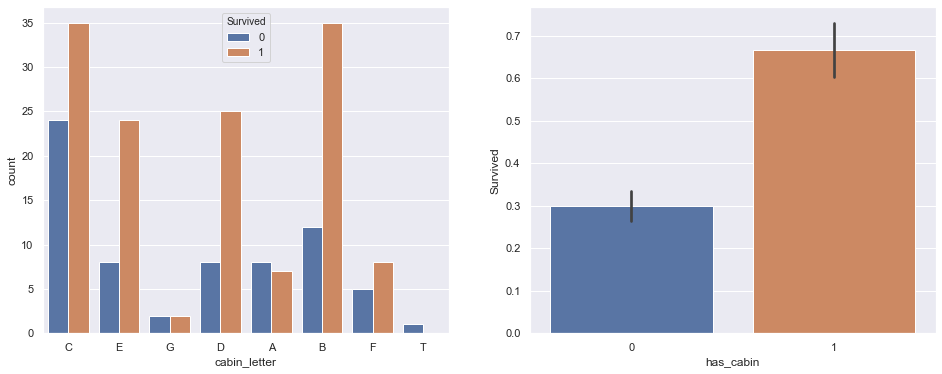

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

train_df['cabin_letter'] = train_df.loc[train_df['Cabin'].notna(), 'Cabin'].str.extract(r'(\w)')
sns.countplot(x='cabin_letter', hue='Survived', data=train_df, ax=ax1)

train_df['cabin_letter'].fillna('Empty', inplace=True)
train_df['has_cabin'] = 0
train_df.loc[train_df['cabin_letter'] != 'Empty', 'has_cabin'] = 1
sns.barplot(x='has_cabin', y='Survived', data=train_df, ax=ax2)

During the cruise it was better to be richer than poorer. It seems that people who decieded to pay more the the cruise had more chances to survive.

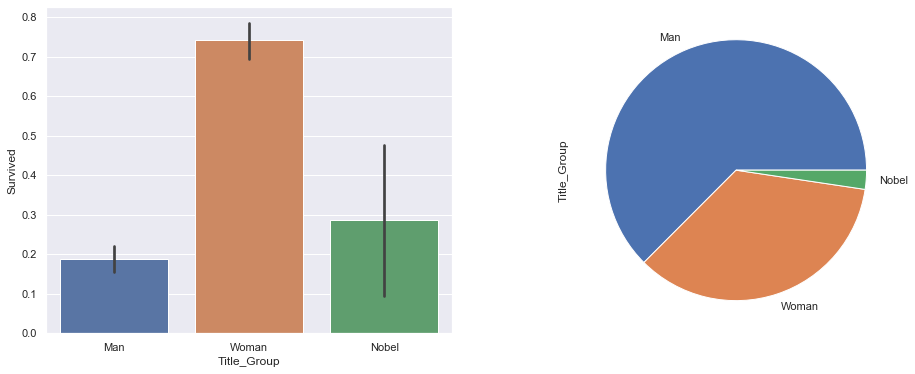

In [225]:
train_df['Title'] = train_df['Name'].str.extract(r'(\w+)\.')
train_df['Title'].unique()

def get_title(text):
    men_title = ['Mr', 'Master']
    if text in men_title:
        return 'Man'
    women_title = ['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'Countess', 'Dona']
    if text in women_title:
        return 'Woman'
    noble = ['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev']
    if text in noble:
        return 'Nobel'
    return 'Other'

train_df['Title_Group'] = train_df['Title'].apply(get_title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x='Title_Group', y='Survived', data=train_df, ax=ax1)
train_df['Title_Group'].value_counts().plot(kind='pie', ax=ax2)

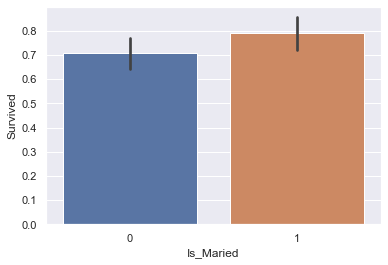

In [221]:
train_df['Is_Maried'] = 0
train_df.loc[train_df['Title'] == 'Mrs', 'Is_Maried'] = 1

sns.barplot(x='Is_Maried', y='Survived', data=train_df.loc[train_df['Title_Group']=='Woman'])

**Preprocessing**

After getting know data. It is time for processing and feature engineering.

In [12]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_cat
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,17
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,5
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,16
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,5


In [13]:
from sklearn.impute import SimpleImputer 
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Sex', 'Embarked']

In [14]:
num_imputer = SimpleImputer(strategy='mean')
num_df = train_df[num_cols]
num_df = num_imputer.fit_transform(num_df)
num_df = pd.DataFrame(num_df, columns=num_cols)

In [15]:
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_df = train_df[cat_cols]
cat_df = cat_imputer.fit_transform(cat_df)
cat_df = pd.DataFrame(cat_df, columns=cat_cols)
cat_df = pd.get_dummies(cat_df)
result = num_df.join(cat_df)

Machine learning

In [20]:
X = result.values
Y = train_df['Survived']

In [36]:
params = {
    'n_estimators': [100, 130, 150, 170, 200],
    'max_depth': [8, 9, 10],
    'criterion': ['gini', 'entropy'],
    'random_state': [42],
}
model = RandomForestClassifier()
rf_grid_search = GridSearchCV(model, param_grid=params, cv=10)
rf_grid_search.fit(X, Y)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] criterion=gini, max_depth=8, n_estimators=3, random_state=42 ....
[CV]  criterion=gini, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=gini, max_depth=8, n_estimators=3, random_state=42 ....
[CV]  criterion=gini, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=gini, max_depth=8, n_estimators=3, random_state=42 ....
[CV]  criterion=gini, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=gini, max_depth=8, n_estimators=3, random_state=42 ....
[CV]  criterion=gini, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=gini, max_depth=8, n_estimators=3, random_state=42 ....
[CV]  criterion=gini, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=gini, max_depth=8, n_estimators=3, random_state=42 ....
[CV]  criterion=gini, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=gini

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_depth=8, n_estimators=30, random_state=42, total=   0.1s
[CV] criterion=gini, max_depth=8, n_estimators=30, random_state=42 ...
[CV]  criterion=gini, max_depth=8, n_estimators=30, random_state=42, total=   0.2s
[CV] criterion=gini, max_depth=8, n_estimators=30, random_state=42 ...
[CV]  criterion=gini, max_depth=8, n_estimators=30, random_state=42, total=   0.2s
[CV] criterion=gini, max_depth=8, n_estimators=30, random_state=42 ...
[CV]  criterion=gini, max_depth=8, n_estimators=30, random_state=42, total=   0.2s
[CV] criterion=gini, max_depth=8, n_estimators=30, random_state=42 ...
[CV]  criterion=gini, max_depth=8, n_estimators=30, random_state=42, total=   0.2s
[CV] criterion=gini, max_depth=8, n_estimators=30, random_state=42 ...
[CV]  criterion=gini, max_depth=8, n_estimators=30, random_state=42, total=   0.3s
[CV] criterion=gini, max_depth=8, n_estimators=30, random_state=42 ...
[CV]  criterion=gini, max_depth=8, n_estimators=30, random_state=42, total= 

[CV]  criterion=gini, max_depth=9, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=gini, max_depth=9, n_estimators=100, random_state=42 ..
[CV]  criterion=gini, max_depth=9, n_estimators=100, random_state=42, total=   0.6s
[CV] criterion=gini, max_depth=9, n_estimators=100, random_state=42 ..
[CV]  criterion=gini, max_depth=9, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=gini, max_depth=9, n_estimators=100, random_state=42 ..
[CV]  criterion=gini, max_depth=9, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=gini, max_depth=9, n_estimators=100, random_state=42 ..
[CV]  criterion=gini, max_depth=9, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=gini, max_depth=9, n_estimators=100, random_state=42 ..
[CV]  criterion=gini, max_depth=9, n_estimators=100, random_state=42, total=   0.3s
[CV] criterion=gini, max_depth=9, n_estimators=150, random_state=42 ..
[CV]  criterion=gini, max_depth=9, n_estimators=150, random_state=42, 

[CV]  criterion=gini, max_depth=10, n_estimators=150, random_state=42, total=   0.5s
[CV] criterion=gini, max_depth=10, n_estimators=150, random_state=42 .
[CV]  criterion=gini, max_depth=10, n_estimators=150, random_state=42, total=   0.5s
[CV] criterion=gini, max_depth=10, n_estimators=150, random_state=42 .
[CV]  criterion=gini, max_depth=10, n_estimators=150, random_state=42, total=   0.8s
[CV] criterion=entropy, max_depth=8, n_estimators=3, random_state=42 .
[CV]  criterion=entropy, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=entropy, max_depth=8, n_estimators=3, random_state=42 .
[CV]  criterion=entropy, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=entropy, max_depth=8, n_estimators=3, random_state=42 .
[CV]  criterion=entropy, max_depth=8, n_estimators=3, random_state=42, total=   0.0s
[CV] criterion=entropy, max_depth=8, n_estimators=3, random_state=42 .
[CV]  criterion=entropy, max_depth=8, n_estimators=3, random_sta

[CV]  criterion=entropy, max_depth=9, n_estimators=30, random_state=42, total=   0.2s
[CV] criterion=entropy, max_depth=9, n_estimators=30, random_state=42 
[CV]  criterion=entropy, max_depth=9, n_estimators=30, random_state=42, total=   0.1s
[CV] criterion=entropy, max_depth=9, n_estimators=30, random_state=42 
[CV]  criterion=entropy, max_depth=9, n_estimators=30, random_state=42, total=   0.1s
[CV] criterion=entropy, max_depth=9, n_estimators=30, random_state=42 
[CV]  criterion=entropy, max_depth=9, n_estimators=30, random_state=42, total=   0.1s
[CV] criterion=entropy, max_depth=9, n_estimators=30, random_state=42 
[CV]  criterion=entropy, max_depth=9, n_estimators=30, random_state=42, total=   0.1s
[CV] criterion=entropy, max_depth=9, n_estimators=30, random_state=42 
[CV]  criterion=entropy, max_depth=9, n_estimators=30, random_state=42, total=   0.1s
[CV] criterion=entropy, max_depth=9, n_estimators=30, random_state=42 
[CV]  criterion=entropy, max_depth=9, n_estimators=30, ran

[CV]  criterion=entropy, max_depth=10, n_estimators=100, random_state=42, total=   0.3s
[CV] criterion=entropy, max_depth=10, n_estimators=100, random_state=42 
[CV]  criterion=entropy, max_depth=10, n_estimators=100, random_state=42, total=   0.8s
[CV] criterion=entropy, max_depth=10, n_estimators=100, random_state=42 
[CV]  criterion=entropy, max_depth=10, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=entropy, max_depth=10, n_estimators=100, random_state=42 
[CV]  criterion=entropy, max_depth=10, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=entropy, max_depth=10, n_estimators=100, random_state=42 
[CV]  criterion=entropy, max_depth=10, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=entropy, max_depth=10, n_estimators=100, random_state=42 
[CV]  criterion=entropy, max_depth=10, n_estimators=100, random_state=42, total=   0.4s
[CV] criterion=entropy, max_depth=10, n_estimators=100, random_state=42 
[CV]  criterion=entropy, max_depth

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  1.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand